In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [3]:
df.columns = ['Sales']

In [4]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
Sales    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


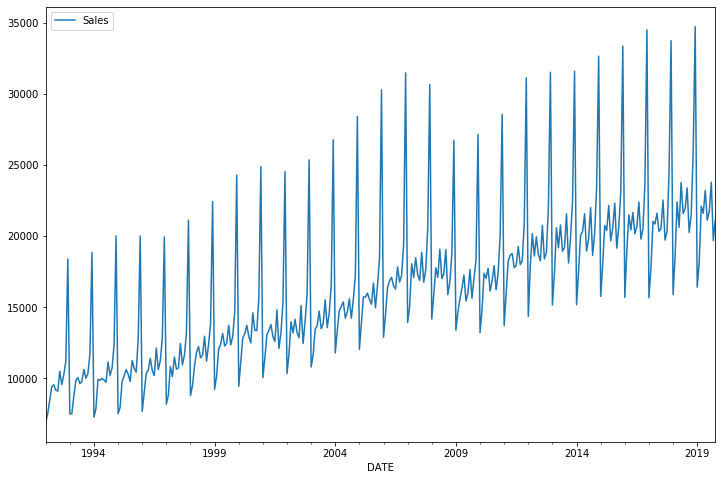

In [6]:
df.plot(figsize=(12, 8))

In [7]:
len(df)

334

In [8]:
test_size = 18
test_ind = len(df) - test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 12
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, 
                               length=length, batch_size=batch_size)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [16]:
n_features = 1

In [17]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [20]:
length = 12
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size=1)

In [21]:
model.fit_generator(generator, 
                    epochs=20, 
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0218 - val_loss: 0.0036
Epoch 2/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0173 - val_loss: 0.0081
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0101 - val_loss: 0.0029
Epoch 4/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0037 - val_loss: 4.3964e-04
Epoch 5/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 0.0109
Epoch 6/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0025 - val_loss: 0.0017


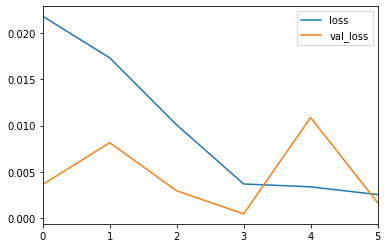

In [22]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [23]:
predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [24]:
true_predictions = scaler.inverse_transform(predictions)

In [25]:
test['Predictions'] = true_predictions

/Users/nathzi1505/Desktop/Private/Online-Courses/TF_2.0/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


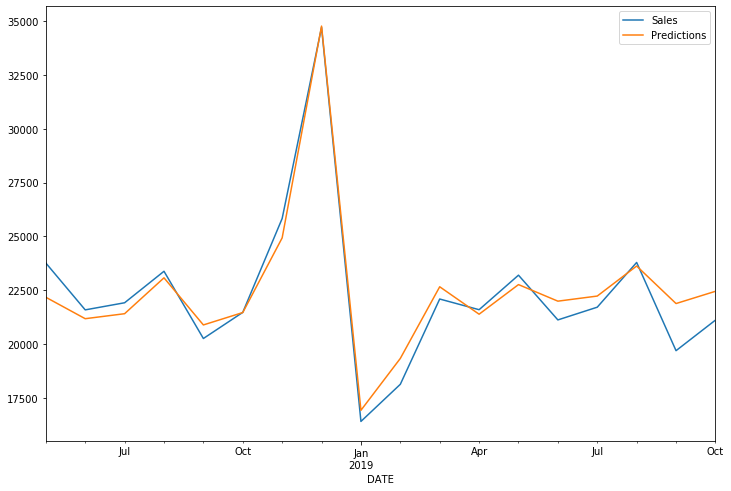

In [26]:
test.plot(figsize=(12, 8))

# Forecast

In [27]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [28]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [29]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0273
Epoch 2/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0176
Epoch 3/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0100
Epoch 4/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0058
Epoch 5/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0023
Epoch 6/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0029
Epoch 7/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0018
Epoch 8/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0012


In [30]:
forecast = []
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
forecast = scaler.inverse_transform(forecast)

In [32]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods, freq='MS')

In [33]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

(576, 611)

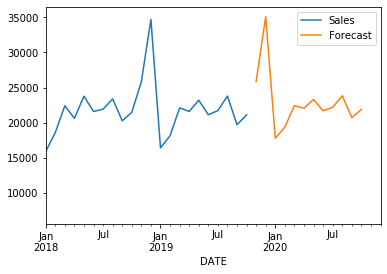

In [34]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')